In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import ContactAveraging
from june.infection import Infection
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.logger.read_logger import ReadLogger
from june.infection.infection import InfectionSelector
from june.world import generate_world_from_hdf5, generate_world_from_geography

No --data argument given - defaulting to:
/cosma7/data/dp004/dc-cues1/JUNE/data
No --configs argument given - defaulting to:
/cosma7/data/dp004/dc-cues1/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = "../configs/config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
        {
            "super_area": [
                "E02003282",
                "E02001720",
                "E02002560",
                "E02002559",
                "E02004314",
            ]
        }
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True, include_commute=True)

2020-07-18 15:55:17,975 - june.demography.geography - INFO - There are 129 areas and 5 super_areas in the world.
2020-07-18 15:55:17,981 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-07-18 15:55:18,020 - june.groups.school - INFO - There are 19 schools in this geography.
2020-07-18 15:55:18,040 - june.groups.school - INFO - No school for the age 0 in this world.
2020-07-18 15:55:18,042 - june.groups.school - INFO - No school for the age 1 in this world.
2020-07-18 15:55:18,045 - june.groups.school - INFO - No school for the age 2 in this world.
2020-07-18 15:55:18,272 - june.groups.carehome - INFO - There are 9 care_homes in this geography.
2020-07-18 15:55:23,340 - numexpr.utils - INFO - Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-07-18 15:55:23,343 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2020-07-18 15:55:27,232 - june.distributors.worker_distributor - INFO - There are 0 who had

## Commute, travel and leisure

In [6]:
world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_households(world.households) # this assigns possible social venues to people.

We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [7]:
world.cemeteries = Cemeteries()

In [8]:
len(world.people)

46784

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [9]:
world.to_hdf5("world.hdf5")

If we would like to load the world we saved, we just do

In [10]:
world = generate_world_from_hdf5("world.hdf5")

loading population from hdf5 .
loading companies from hdf5 .
loading households from hdf5 .

  0%|          | 0/46784 [00:00<?, ?it/s]


restoring world...


100%|██████████| 46784/46784 [00:00<00:00, 71657.21it/s] 


In [11]:
world.pubs

In [12]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)

you have now a beautiful pre-pandemic world. 

# Adding the infection

Now, you can play around with different models of infections. The building blocks for an infection are: Transmission and Symptoms. For now, only SymptomsConstant and TransmissionConstant are in a state to be used.

In [13]:
selector = InfectionSelector.from_file()

# Adding the interaction

In [14]:
interaction = ContactAveraging.from_file(selector=selector)

Beta are the intensities of the interaction taking place at the different groups

In [15]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 1.0,
 'commute_city_unit': 1.0,
 'hospital': 1.0,
 'care_home': 1.0,
 'company': 0.1,
 'school': 0.1,
 'household': 0.2,
 'university': 0.01}

to modify these, simply do

In [16]:
for key in interaction.beta.keys():
    interaction.beta[key] *= 2

In [17]:
interaction.beta

{'box': 2,
 'pub': 0.2,
 'grocery': 0.2,
 'cinema': 0.2,
 'commute_unit': 2.0,
 'commute_city_unit': 2.0,
 'hospital': 2.0,
 'care_home': 2.0,
 'company': 0.2,
 'school': 0.2,
 'household': 0.4,
 'university': 0.02}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [18]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [19]:
infection_seed = InfectionSeed(
    world.super_areas, selector,
)

In [20]:
n_cases = 50
infection_seed.unleash_virus(n_cases) # play around with the initial number of cases

# Set policies

In [21]:
policies = Policies.from_file()

# Run the simulation

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [22]:
simulator = Simulator.from_file(
     world, interaction, selector, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    policies = policies
)

In [23]:
%%time
simulator.run()

2020-07-18 15:56:08,405 - june.simulator - INFO - Starting group_dynamics for 250 days at day 0
2020-07-18 15:56:08,407 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 250 days
2020-07-18 15:56:09,898 - june.simulator - INFO - Date = 2020-03-01 04:00:00, number of deaths =  0, number of infected = 50
2020-07-18 15:56:10,746 - june.simulator - INFO - Date = 2020-03-01 08:00:00, number of deaths =  0, number of infected = 50
2020-07-18 15:56:11,225 - june.simulator - INFO - Date = 2020-03-01 12:00:00, number of deaths =  0, number of infected = 50
2020-07-18 15:56:11,811 - june.simulator - INFO - Date = 2020-03-02 00:00:00, number of deaths =  0, number of infected = 50
2020-07-18 15:56:12,367 - june.simulator - INFO - Date = 2020-03-02 01:00:00, number of deaths =  0, number of infected = 50
2020-07-18 15:56:12,765 - june.simulator - INFO - Date = 2020-03-02 09:00:00, number of deaths =  0, number of infected = 52
2020-07-18 15:56:13,518 - june.simulator - INFO - 

2020-07-18 15:56:50,143 - june.simulator - INFO - Date = 2020-03-14 12:00:00, number of deaths =  0, number of infected = 902
2020-07-18 15:56:51,050 - june.simulator - INFO - Date = 2020-03-15 00:00:00, number of deaths =  0, number of infected = 963
2020-07-18 15:56:51,863 - june.simulator - INFO - Date = 2020-03-15 04:00:00, number of deaths =  0, number of infected = 999
2020-07-18 15:56:52,686 - june.simulator - INFO - Date = 2020-03-15 08:00:00, number of deaths =  0, number of infected = 1039
2020-07-18 15:56:53,282 - june.simulator - INFO - Date = 2020-03-15 12:00:00, number of deaths =  0, number of infected = 1069
2020-07-18 15:56:54,317 - june.simulator - INFO - Date = 2020-03-16 00:00:00, number of deaths =  0, number of infected = 1128
2020-07-18 15:56:55,375 - june.simulator - INFO - Date = 2020-03-16 01:00:00, number of deaths =  0, number of infected = 1151
2020-07-18 15:56:56,695 - june.simulator - INFO - Date = 2020-03-16 09:00:00, number of deaths =  0, number of inf

2020-07-18 15:58:03,039 - june.simulator - INFO - Date = 2020-03-28 08:00:00, number of deaths =  3, number of infected = 4974
2020-07-18 15:58:04,019 - june.simulator - INFO - Date = 2020-03-28 12:00:00, number of deaths =  3, number of infected = 5025
2020-07-18 15:58:06,439 - june.simulator - INFO - Date = 2020-03-29 00:00:00, number of deaths =  4, number of infected = 5170
2020-07-18 15:58:07,597 - june.simulator - INFO - Date = 2020-03-29 04:00:00, number of deaths =  4, number of infected = 5224
2020-07-18 15:58:08,722 - june.simulator - INFO - Date = 2020-03-29 08:00:00, number of deaths =  4, number of infected = 5272
2020-07-18 15:58:09,674 - june.simulator - INFO - Date = 2020-03-29 12:00:00, number of deaths =  4, number of infected = 5330
2020-07-18 15:58:10,988 - june.simulator - INFO - Date = 2020-03-30 00:00:00, number of deaths =  4, number of infected = 5447
2020-07-18 15:58:11,912 - june.simulator - INFO - Date = 2020-03-30 01:00:00, number of deaths =  4, number of 

2020-07-18 15:59:16,594 - june.simulator - INFO - Date = 2020-04-11 04:00:00, number of deaths =  17, number of infected = 7556
2020-07-18 15:59:17,680 - june.simulator - INFO - Date = 2020-04-11 08:00:00, number of deaths =  17, number of infected = 7557
2020-07-18 15:59:18,669 - june.simulator - INFO - Date = 2020-04-11 12:00:00, number of deaths =  17, number of infected = 7555
2020-07-18 15:59:19,971 - june.simulator - INFO - Date = 2020-04-12 00:00:00, number of deaths =  19, number of infected = 7526
2020-07-18 15:59:20,988 - june.simulator - INFO - Date = 2020-04-12 04:00:00, number of deaths =  19, number of infected = 7509
2020-07-18 15:59:22,062 - june.simulator - INFO - Date = 2020-04-12 08:00:00, number of deaths =  19, number of infected = 7493
2020-07-18 15:59:23,047 - june.simulator - INFO - Date = 2020-04-12 12:00:00, number of deaths =  19, number of infected = 7476
2020-07-18 15:59:24,145 - june.simulator - INFO - Date = 2020-04-13 00:00:00, number of deaths =  19, nu

2020-07-18 16:00:23,365 - june.simulator - INFO - Date = 2020-04-25 00:00:00, number of deaths =  35, number of infected = 5721
2020-07-18 16:00:24,296 - june.simulator - INFO - Date = 2020-04-25 04:00:00, number of deaths =  35, number of infected = 5668
2020-07-18 16:00:25,216 - june.simulator - INFO - Date = 2020-04-25 08:00:00, number of deaths =  36, number of infected = 5634
2020-07-18 16:00:26,027 - june.simulator - INFO - Date = 2020-04-25 12:00:00, number of deaths =  36, number of infected = 5610
2020-07-18 16:00:27,181 - june.simulator - INFO - Date = 2020-04-26 00:00:00, number of deaths =  36, number of infected = 5506
2020-07-18 16:00:28,144 - june.simulator - INFO - Date = 2020-04-26 04:00:00, number of deaths =  36, number of infected = 5463
2020-07-18 16:00:29,050 - june.simulator - INFO - Date = 2020-04-26 08:00:00, number of deaths =  36, number of infected = 5434
2020-07-18 16:00:29,853 - june.simulator - INFO - Date = 2020-04-26 12:00:00, number of deaths =  36, nu

2020-07-18 16:01:21,275 - june.simulator - INFO - Date = 2020-05-08 13:00:00, number of deaths =  45, number of infected = 3637
2020-07-18 16:01:22,302 - june.simulator - INFO - Date = 2020-05-09 00:00:00, number of deaths =  45, number of infected = 3572
2020-07-18 16:01:23,176 - june.simulator - INFO - Date = 2020-05-09 04:00:00, number of deaths =  45, number of infected = 3552
2020-07-18 16:01:24,041 - june.simulator - INFO - Date = 2020-05-09 08:00:00, number of deaths =  45, number of infected = 3531
2020-07-18 16:01:24,746 - june.simulator - INFO - Date = 2020-05-09 12:00:00, number of deaths =  45, number of infected = 3509
2020-07-18 16:01:25,761 - june.simulator - INFO - Date = 2020-05-10 00:00:00, number of deaths =  45, number of infected = 3443
2020-07-18 16:01:26,788 - june.simulator - INFO - Date = 2020-05-10 04:00:00, number of deaths =  45, number of infected = 3442
2020-07-18 16:01:27,675 - june.simulator - INFO - Date = 2020-05-10 08:00:00, number of deaths =  45, nu

2020-07-18 16:02:14,675 - june.simulator - INFO - Date = 2020-05-22 10:00:00, number of deaths =  49, number of infected = 2503
2020-07-18 16:02:15,382 - june.simulator - INFO - Date = 2020-05-22 13:00:00, number of deaths =  49, number of infected = 2498
2020-07-18 16:02:16,391 - june.simulator - INFO - Date = 2020-05-23 00:00:00, number of deaths =  49, number of infected = 2460
2020-07-18 16:02:17,214 - june.simulator - INFO - Date = 2020-05-23 04:00:00, number of deaths =  49, number of infected = 2440
2020-07-18 16:02:18,054 - june.simulator - INFO - Date = 2020-05-23 08:00:00, number of deaths =  49, number of infected = 2423
2020-07-18 16:02:18,839 - june.simulator - INFO - Date = 2020-05-23 12:00:00, number of deaths =  49, number of infected = 2418
2020-07-18 16:02:19,738 - june.simulator - INFO - Date = 2020-05-24 00:00:00, number of deaths =  49, number of infected = 2376
2020-07-18 16:02:20,569 - june.simulator - INFO - Date = 2020-05-24 04:00:00, number of deaths =  49, nu

2020-07-18 16:03:05,168 - june.simulator - INFO - Date = 2020-06-05 09:00:00, number of deaths =  58, number of infected = 1580
2020-07-18 16:03:05,940 - june.simulator - INFO - Date = 2020-06-05 10:00:00, number of deaths =  58, number of infected = 1580
2020-07-18 16:03:06,558 - june.simulator - INFO - Date = 2020-06-05 13:00:00, number of deaths =  58, number of infected = 1569
2020-07-18 16:03:07,408 - june.simulator - INFO - Date = 2020-06-06 00:00:00, number of deaths =  58, number of infected = 1549
2020-07-18 16:03:08,197 - june.simulator - INFO - Date = 2020-06-06 04:00:00, number of deaths =  58, number of infected = 1543
2020-07-18 16:03:08,999 - june.simulator - INFO - Date = 2020-06-06 08:00:00, number of deaths =  58, number of infected = 1539
2020-07-18 16:03:09,727 - june.simulator - INFO - Date = 2020-06-06 12:00:00, number of deaths =  58, number of infected = 1524
2020-07-18 16:03:10,553 - june.simulator - INFO - Date = 2020-06-07 00:00:00, number of deaths =  59, nu

2020-07-18 16:03:53,487 - june.simulator - INFO - Date = 2020-06-19 01:00:00, number of deaths =  63, number of infected = 951
2020-07-18 16:03:54,143 - june.simulator - INFO - Date = 2020-06-19 09:00:00, number of deaths =  63, number of infected = 944
2020-07-18 16:03:54,840 - june.simulator - INFO - Date = 2020-06-19 10:00:00, number of deaths =  63, number of infected = 940
2020-07-18 16:03:55,427 - june.simulator - INFO - Date = 2020-06-19 13:00:00, number of deaths =  63, number of infected = 929
2020-07-18 16:03:56,196 - june.simulator - INFO - Date = 2020-06-20 00:00:00, number of deaths =  63, number of infected = 908
2020-07-18 16:03:56,921 - june.simulator - INFO - Date = 2020-06-20 04:00:00, number of deaths =  63, number of infected = 906
2020-07-18 16:03:57,636 - june.simulator - INFO - Date = 2020-06-20 08:00:00, number of deaths =  64, number of infected = 897
2020-07-18 16:03:58,268 - june.simulator - INFO - Date = 2020-06-20 12:00:00, number of deaths =  64, number of

2020-07-18 16:04:38,560 - june.simulator - INFO - Date = 2020-07-03 00:00:00, number of deaths =  65, number of infected = 546
2020-07-18 16:04:39,341 - june.simulator - INFO - Date = 2020-07-03 01:00:00, number of deaths =  65, number of infected = 546
2020-07-18 16:04:40,017 - june.simulator - INFO - Date = 2020-07-03 09:00:00, number of deaths =  65, number of infected = 543
2020-07-18 16:04:40,798 - june.simulator - INFO - Date = 2020-07-03 10:00:00, number of deaths =  65, number of infected = 543
2020-07-18 16:04:41,403 - june.simulator - INFO - Date = 2020-07-03 13:00:00, number of deaths =  65, number of infected = 539
2020-07-18 16:04:42,091 - june.simulator - INFO - Date = 2020-07-04 00:00:00, number of deaths =  65, number of infected = 527
2020-07-18 16:04:42,791 - june.simulator - INFO - Date = 2020-07-04 04:00:00, number of deaths =  65, number of infected = 530
2020-07-18 16:04:43,472 - june.simulator - INFO - Date = 2020-07-04 08:00:00, number of deaths =  66, number of

2020-07-18 16:05:18,424 - june.simulator - INFO - Date = 2020-07-16 13:00:00, number of deaths =  66, number of infected = 535
2020-07-18 16:05:19,006 - june.simulator - INFO - Date = 2020-07-17 00:00:00, number of deaths =  66, number of infected = 541
2020-07-18 16:05:19,635 - june.simulator - INFO - Date = 2020-07-17 01:00:00, number of deaths =  66, number of infected = 542
2020-07-18 16:05:20,140 - june.simulator - INFO - Date = 2020-07-17 09:00:00, number of deaths =  66, number of infected = 549
2020-07-18 16:05:20,797 - june.simulator - INFO - Date = 2020-07-17 10:00:00, number of deaths =  66, number of infected = 549
2020-07-18 16:05:21,318 - june.simulator - INFO - Date = 2020-07-17 13:00:00, number of deaths =  66, number of infected = 552
2020-07-18 16:05:22,043 - june.simulator - INFO - Date = 2020-07-18 00:00:00, number of deaths =  66, number of infected = 556
2020-07-18 16:05:22,744 - june.simulator - INFO - Date = 2020-07-18 04:00:00, number of deaths =  66, number of

2020-07-18 16:05:57,511 - june.simulator - INFO - Date = 2020-07-30 10:00:00, number of deaths =  66, number of infected = 778
2020-07-18 16:05:57,971 - june.simulator - INFO - Date = 2020-07-30 13:00:00, number of deaths =  66, number of infected = 777
2020-07-18 16:05:58,515 - june.simulator - INFO - Date = 2020-07-31 00:00:00, number of deaths =  66, number of infected = 776
2020-07-18 16:05:59,160 - june.simulator - INFO - Date = 2020-07-31 01:00:00, number of deaths =  66, number of infected = 777
2020-07-18 16:05:59,756 - june.simulator - INFO - Date = 2020-07-31 09:00:00, number of deaths =  66, number of infected = 789
2020-07-18 16:06:00,400 - june.simulator - INFO - Date = 2020-07-31 10:00:00, number of deaths =  66, number of infected = 790
2020-07-18 16:06:00,912 - june.simulator - INFO - Date = 2020-07-31 13:00:00, number of deaths =  66, number of infected = 799
2020-07-18 16:06:01,662 - june.simulator - INFO - Date = 2020-08-01 00:00:00, number of deaths =  66, number of

2020-07-18 16:06:37,145 - june.simulator - INFO - Date = 2020-08-13 09:00:00, number of deaths =  69, number of infected = 1039
2020-07-18 16:06:37,802 - june.simulator - INFO - Date = 2020-08-13 10:00:00, number of deaths =  69, number of infected = 1041
2020-07-18 16:06:38,340 - june.simulator - INFO - Date = 2020-08-13 13:00:00, number of deaths =  69, number of infected = 1051
2020-07-18 16:06:38,911 - june.simulator - INFO - Date = 2020-08-14 00:00:00, number of deaths =  69, number of infected = 1056
2020-07-18 16:06:39,526 - june.simulator - INFO - Date = 2020-08-14 01:00:00, number of deaths =  69, number of infected = 1056
2020-07-18 16:06:40,064 - june.simulator - INFO - Date = 2020-08-14 09:00:00, number of deaths =  69, number of infected = 1073
2020-07-18 16:06:40,717 - june.simulator - INFO - Date = 2020-08-14 10:00:00, number of deaths =  69, number of infected = 1072
2020-07-18 16:06:41,220 - june.simulator - INFO - Date = 2020-08-14 13:00:00, number of deaths =  69, nu

2020-07-18 16:07:19,755 - june.simulator - INFO - Date = 2020-08-27 01:00:00, number of deaths =  71, number of infected = 1392
2020-07-18 16:07:20,329 - june.simulator - INFO - Date = 2020-08-27 09:00:00, number of deaths =  71, number of infected = 1405
2020-07-18 16:07:21,043 - june.simulator - INFO - Date = 2020-08-27 10:00:00, number of deaths =  71, number of infected = 1406
2020-07-18 16:07:21,573 - june.simulator - INFO - Date = 2020-08-27 13:00:00, number of deaths =  71, number of infected = 1412
2020-07-18 16:07:22,126 - june.simulator - INFO - Date = 2020-08-28 00:00:00, number of deaths =  71, number of infected = 1409
2020-07-18 16:07:22,745 - june.simulator - INFO - Date = 2020-08-28 01:00:00, number of deaths =  71, number of infected = 1409
2020-07-18 16:07:23,387 - june.simulator - INFO - Date = 2020-08-28 09:00:00, number of deaths =  71, number of infected = 1434
2020-07-18 16:07:24,070 - june.simulator - INFO - Date = 2020-08-28 10:00:00, number of deaths =  71, nu

2020-07-18 16:08:03,037 - june.simulator - INFO - Date = 2020-09-10 00:00:00, number of deaths =  73, number of infected = 1976
2020-07-18 16:08:03,729 - june.simulator - INFO - Date = 2020-09-10 01:00:00, number of deaths =  73, number of infected = 1978
2020-07-18 16:08:04,349 - june.simulator - INFO - Date = 2020-09-10 09:00:00, number of deaths =  73, number of infected = 2001
2020-07-18 16:08:05,024 - june.simulator - INFO - Date = 2020-09-10 10:00:00, number of deaths =  73, number of infected = 2002
2020-07-18 16:08:05,587 - june.simulator - INFO - Date = 2020-09-10 13:00:00, number of deaths =  73, number of infected = 2015
2020-07-18 16:08:06,275 - june.simulator - INFO - Date = 2020-09-11 00:00:00, number of deaths =  74, number of infected = 2016
2020-07-18 16:08:06,969 - june.simulator - INFO - Date = 2020-09-11 01:00:00, number of deaths =  74, number of infected = 2017
2020-07-18 16:08:07,663 - june.simulator - INFO - Date = 2020-09-11 09:00:00, number of deaths =  74, nu

2020-07-18 16:08:49,722 - june.simulator - INFO - Date = 2020-09-23 13:00:00, number of deaths =  76, number of infected = 2477
2020-07-18 16:08:50,386 - june.simulator - INFO - Date = 2020-09-24 00:00:00, number of deaths =  76, number of infected = 2483
2020-07-18 16:08:51,058 - june.simulator - INFO - Date = 2020-09-24 01:00:00, number of deaths =  76, number of infected = 2479
2020-07-18 16:08:51,672 - june.simulator - INFO - Date = 2020-09-24 09:00:00, number of deaths =  76, number of infected = 2487
2020-07-18 16:08:52,345 - june.simulator - INFO - Date = 2020-09-24 10:00:00, number of deaths =  76, number of infected = 2488
2020-07-18 16:08:52,874 - june.simulator - INFO - Date = 2020-09-24 13:00:00, number of deaths =  76, number of infected = 2496
2020-07-18 16:08:53,517 - june.simulator - INFO - Date = 2020-09-25 00:00:00, number of deaths =  76, number of infected = 2502
2020-07-18 16:08:54,156 - june.simulator - INFO - Date = 2020-09-25 01:00:00, number of deaths =  76, nu

2020-07-18 16:09:31,455 - june.simulator - INFO - Date = 2020-10-07 10:00:00, number of deaths =  82, number of infected = 2465
2020-07-18 16:09:31,946 - june.simulator - INFO - Date = 2020-10-07 13:00:00, number of deaths =  82, number of infected = 2460
2020-07-18 16:09:32,519 - june.simulator - INFO - Date = 2020-10-08 00:00:00, number of deaths =  84, number of infected = 2454
2020-07-18 16:09:33,061 - june.simulator - INFO - Date = 2020-10-08 01:00:00, number of deaths =  84, number of infected = 2454
2020-07-18 16:09:33,661 - june.simulator - INFO - Date = 2020-10-08 09:00:00, number of deaths =  84, number of infected = 2456
2020-07-18 16:09:34,346 - june.simulator - INFO - Date = 2020-10-08 10:00:00, number of deaths =  84, number of infected = 2455
2020-07-18 16:09:34,868 - june.simulator - INFO - Date = 2020-10-08 13:00:00, number of deaths =  84, number of infected = 2463
2020-07-18 16:09:35,545 - june.simulator - INFO - Date = 2020-10-09 00:00:00, number of deaths =  84, nu

2020-07-18 16:10:14,356 - june.simulator - INFO - Date = 2020-10-21 09:00:00, number of deaths =  89, number of infected = 2065
2020-07-18 16:10:15,111 - june.simulator - INFO - Date = 2020-10-21 10:00:00, number of deaths =  89, number of infected = 2066
2020-07-18 16:10:15,643 - june.simulator - INFO - Date = 2020-10-21 13:00:00, number of deaths =  89, number of infected = 2062
2020-07-18 16:10:16,251 - june.simulator - INFO - Date = 2020-10-22 00:00:00, number of deaths =  90, number of infected = 2044
2020-07-18 16:10:16,841 - june.simulator - INFO - Date = 2020-10-22 01:00:00, number of deaths =  90, number of infected = 2038
2020-07-18 16:10:17,366 - june.simulator - INFO - Date = 2020-10-22 09:00:00, number of deaths =  90, number of infected = 2017
2020-07-18 16:10:18,159 - june.simulator - INFO - Date = 2020-10-22 10:00:00, number of deaths =  90, number of infected = 2013
2020-07-18 16:10:18,689 - june.simulator - INFO - Date = 2020-10-22 13:00:00, number of deaths =  90, nu

2020-07-18 16:10:52,155 - june.simulator - INFO - Date = 2020-11-04 01:00:00, number of deaths =  94, number of infected = 1477
2020-07-18 16:10:52,617 - june.simulator - INFO - Date = 2020-11-04 09:00:00, number of deaths =  94, number of infected = 1469
2020-07-18 16:10:53,241 - june.simulator - INFO - Date = 2020-11-04 10:00:00, number of deaths =  94, number of infected = 1469
2020-07-18 16:10:53,691 - june.simulator - INFO - Date = 2020-11-04 13:00:00, number of deaths =  94, number of infected = 1469
2020-07-18 16:10:54,185 - june.simulator - INFO - Date = 2020-11-05 00:00:00, number of deaths =  94, number of infected = 1455
2020-07-18 16:10:54,676 - june.simulator - INFO - Date = 2020-11-05 01:00:00, number of deaths =  94, number of infected = 1453
2020-07-18 16:10:55,140 - june.simulator - INFO - Date = 2020-11-05 09:00:00, number of deaths =  94, number of infected = 1443
2020-07-18 16:10:55,768 - june.simulator - INFO - Date = 2020-11-05 10:00:00, number of deaths =  94, nu

While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [24]:
import pandas as pd

In [25]:
read = ReadLogger()

## Hospital data and how it changed over time

In [26]:
hospitals_df = read.load_hospital_capacity()

In [27]:
hospitals_df.head(3)

,time_stamp,id,n_patients,n_patients_icu
0,2020-03-01T04:00:00.000000,0,0,0
1,2020-03-01T08:00:00.000000,0,0,0
2,2020-03-01T12:00:00.000000,0,0,0


In [28]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [29]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds,trust_code
0,0.688477,51.5625,2115,296,RAJ


## where did infections happen?

In [30]:
loc_df = read.get_locations_infections()

In [31]:
locations_per_day = read.locations_df.groupby(pd.Grouper(freq='D')).sum()

In [32]:
all_infection_places = set(locations_per_day.location.sum())

In [33]:
def n_infections(row, infection_place):
    return sum([row.counts[i] for i, x in enumerate(row.location) if x == infection_place])


In [34]:
for infection_place in all_infection_places:
    locations_per_day[str(infection_place)] = locations_per_day.apply(
        lambda x: n_infections(x, infection_place),
        axis=1
    )

In [35]:
locations_per_day = locations_per_day.drop(columns=['location',
                                                    'counts'])

In [36]:
locations_per_day = locations_per_day.div(
    locations_per_day.sum(axis=1), axis=0
)


Text(0, 0.5, 'Percent of infections')

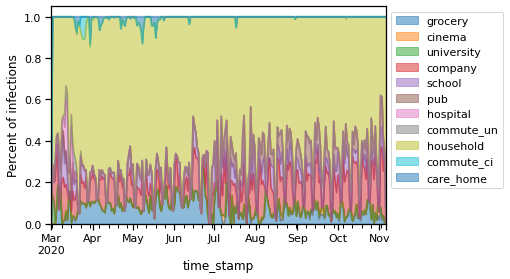

In [37]:
locations_per_day.plot.area( alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Percent of infections')

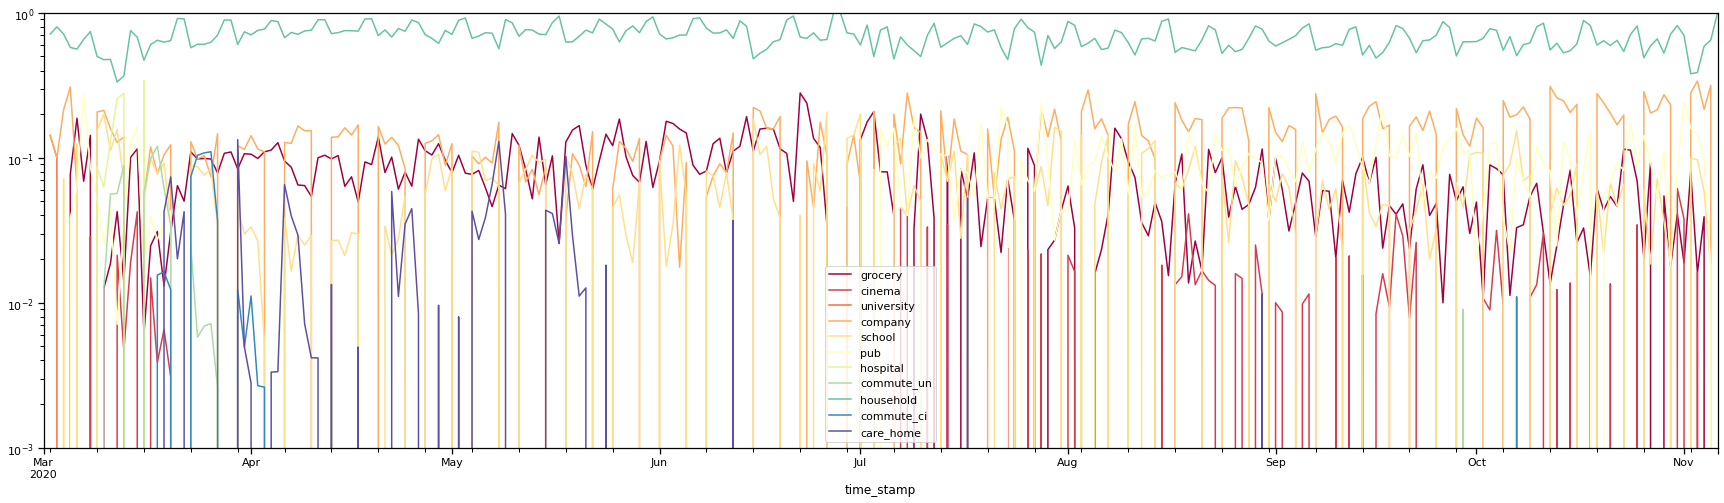

In [38]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

locations_per_day.plot(figsize=(30,8), logy=True, ylim=(1e-3, 1), cmap=cmap)

Text(0.5, 0, 'location')

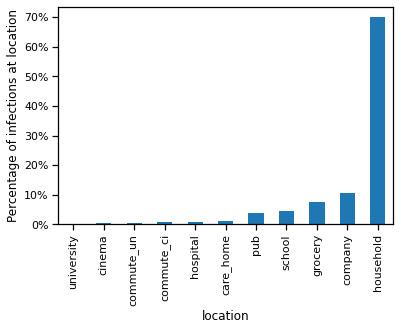

In [39]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')
#plt.yscale('log')

## rate of infection

In [40]:
r_df = read.get_r()

/cosma/home/dp004/dc-cues1/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/cosma/home/dp004/dc-cues1/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'R')

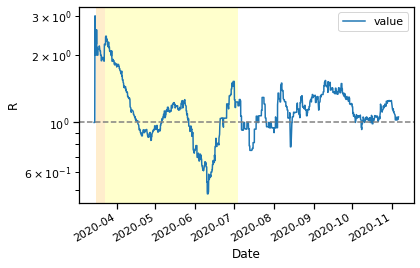

In [41]:
from june.policy import SocialDistancing
r_df.plot()
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.yscale('log')
plt.ylabel('R')

## World infection curves, and by super area

In [42]:
world_df = read.world_summary()

In [45]:
#import matplotlib.pyplot as plt
 
#plt.style.use(['science','notebook'])
#plt.style.reload_library()

In [46]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

Text(0.5, 0, 'Date')

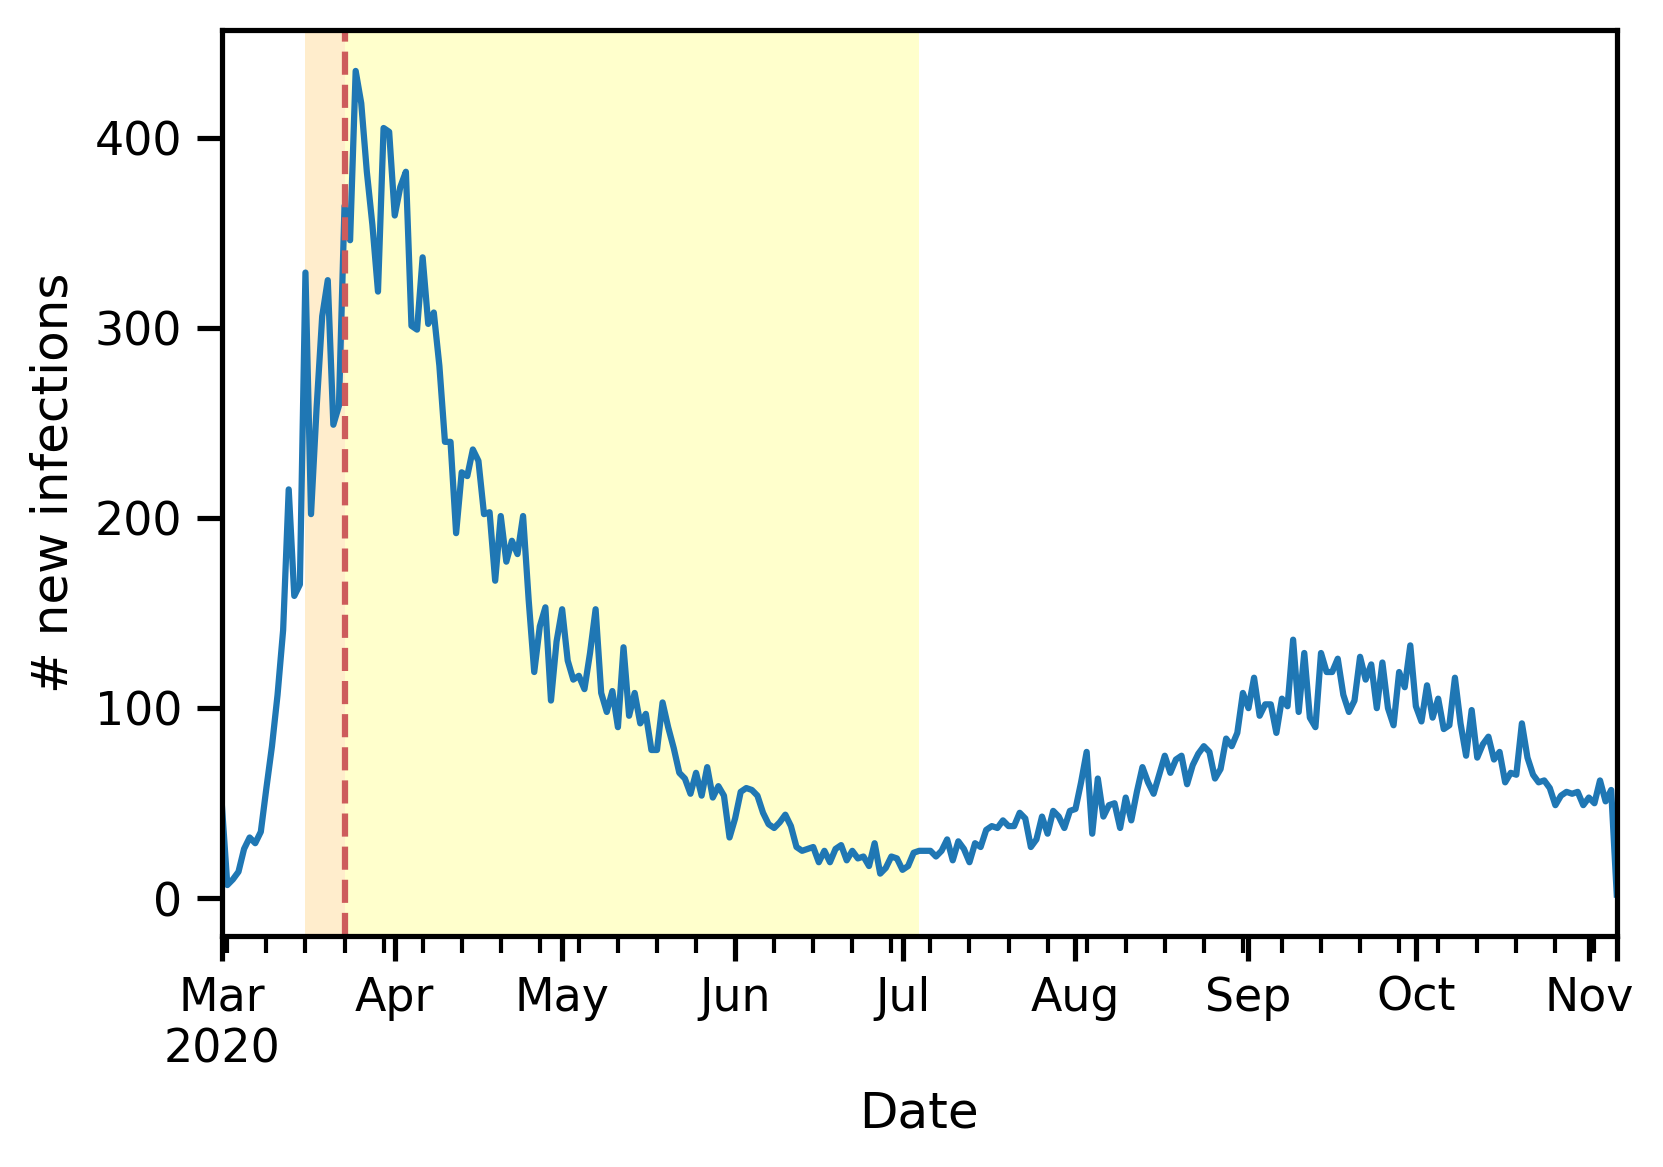

In [48]:
fig, ax = plt.subplots()
world_df['new_infections'].resample('D').sum().plot(ax=ax)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.axvline('2020-03-23',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# new infections')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

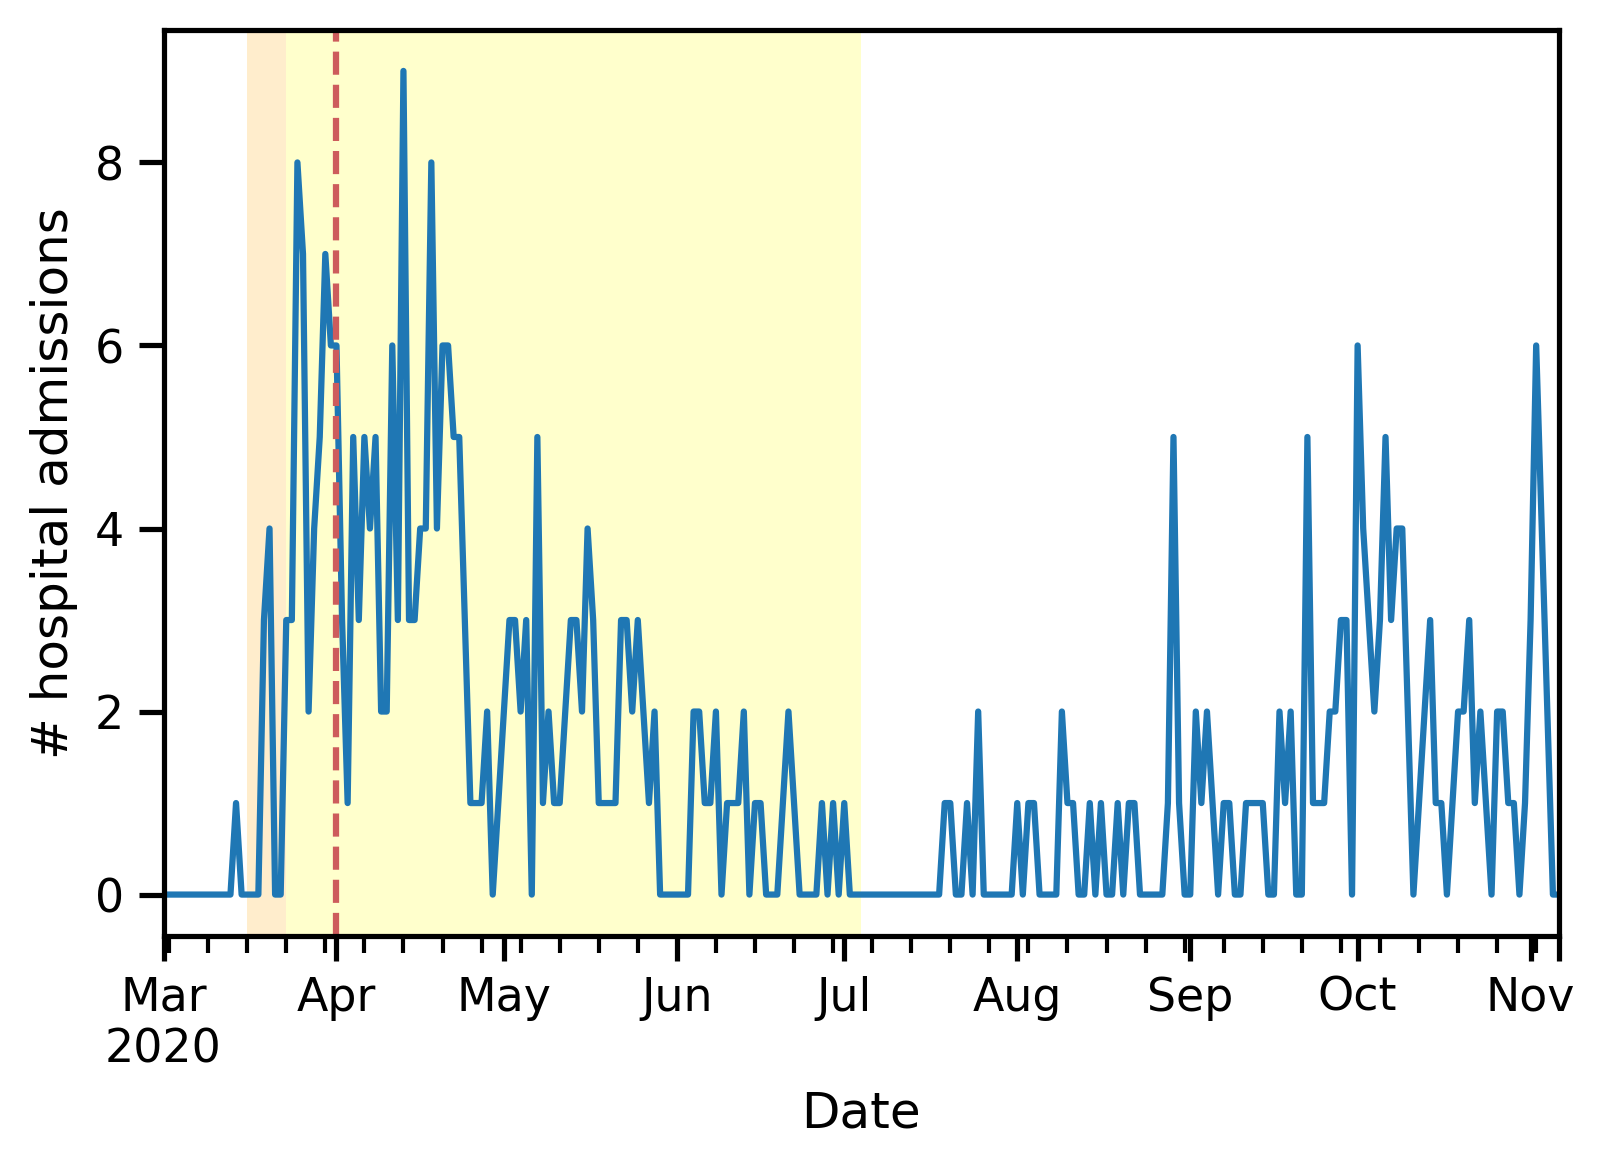

In [54]:
fig, ax = plt.subplots()
(world_df['hospital_admissions']+world_df['intensive_care_admissions']).resample('D').sum().plot(ax=ax)
colors = ["yellow", "orange"]
for policy in policies.polici-es:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.axvline('2020-04-01',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# hospital admissions')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

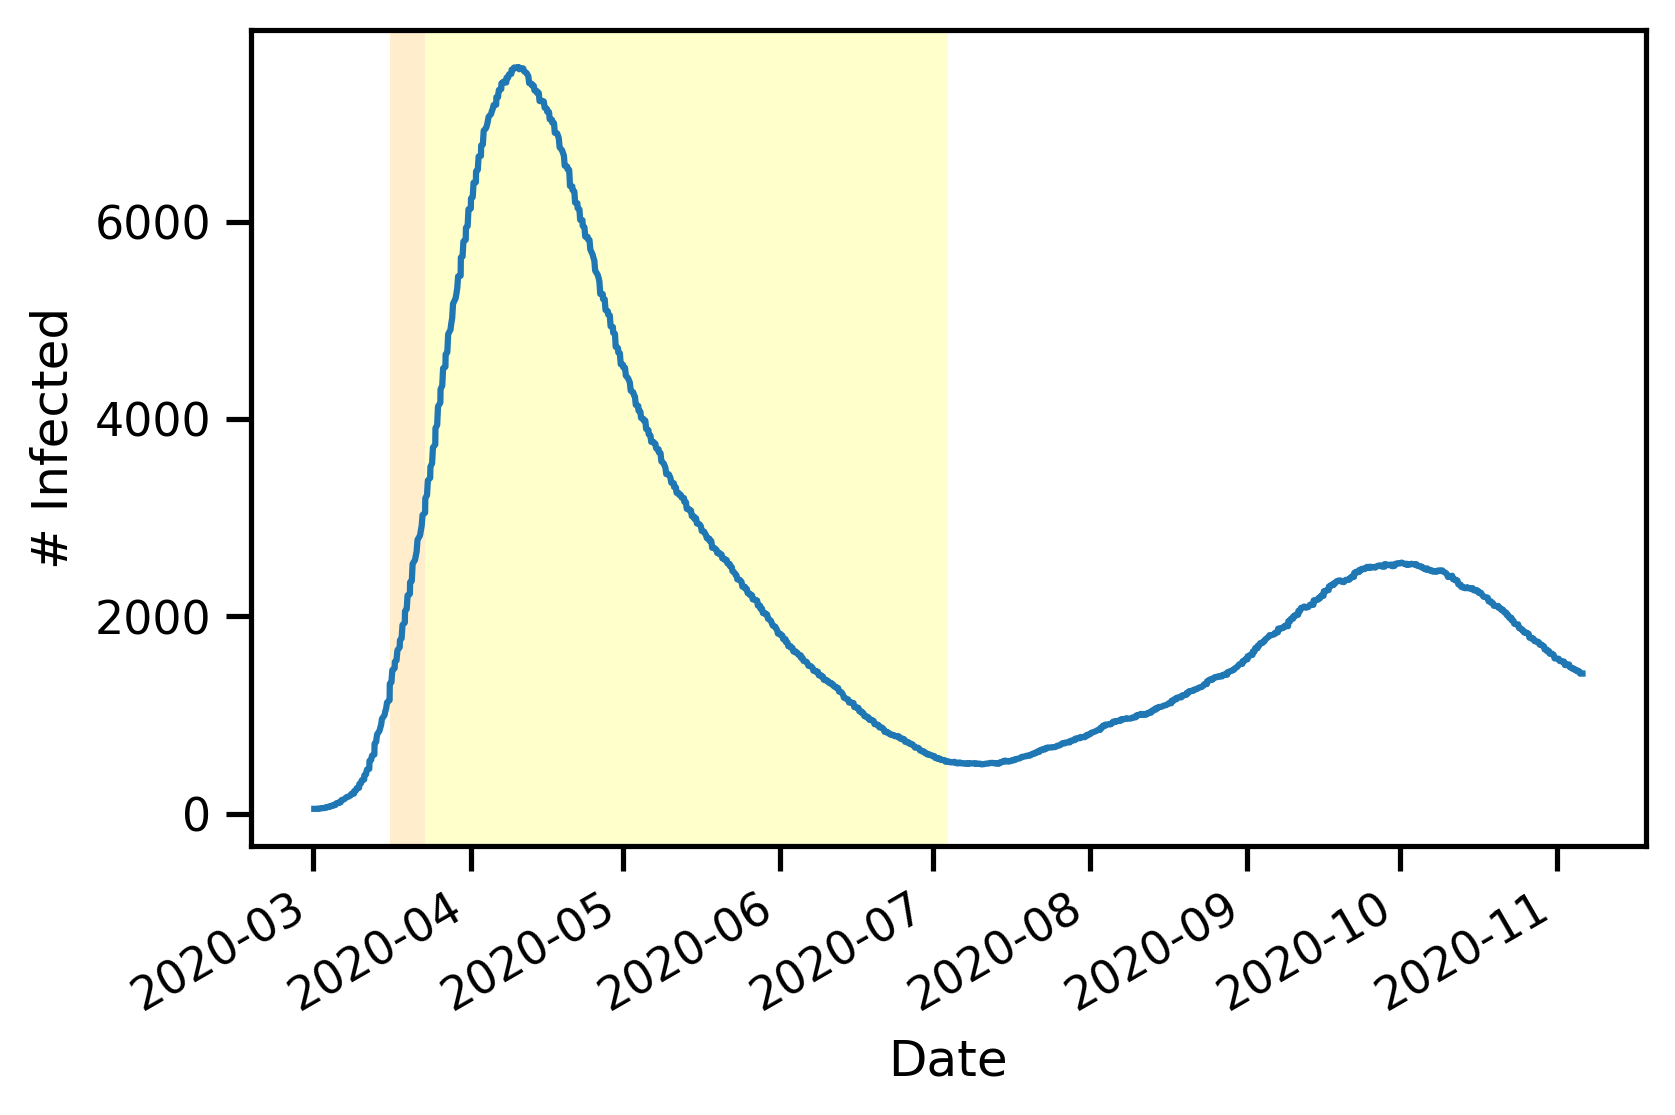

In [49]:
fig, ax = plt.subplots()
world_df['infected'].plot(ax=ax)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
ax.set_ylabel('# Infected')
ax.set_xlabel('Date')

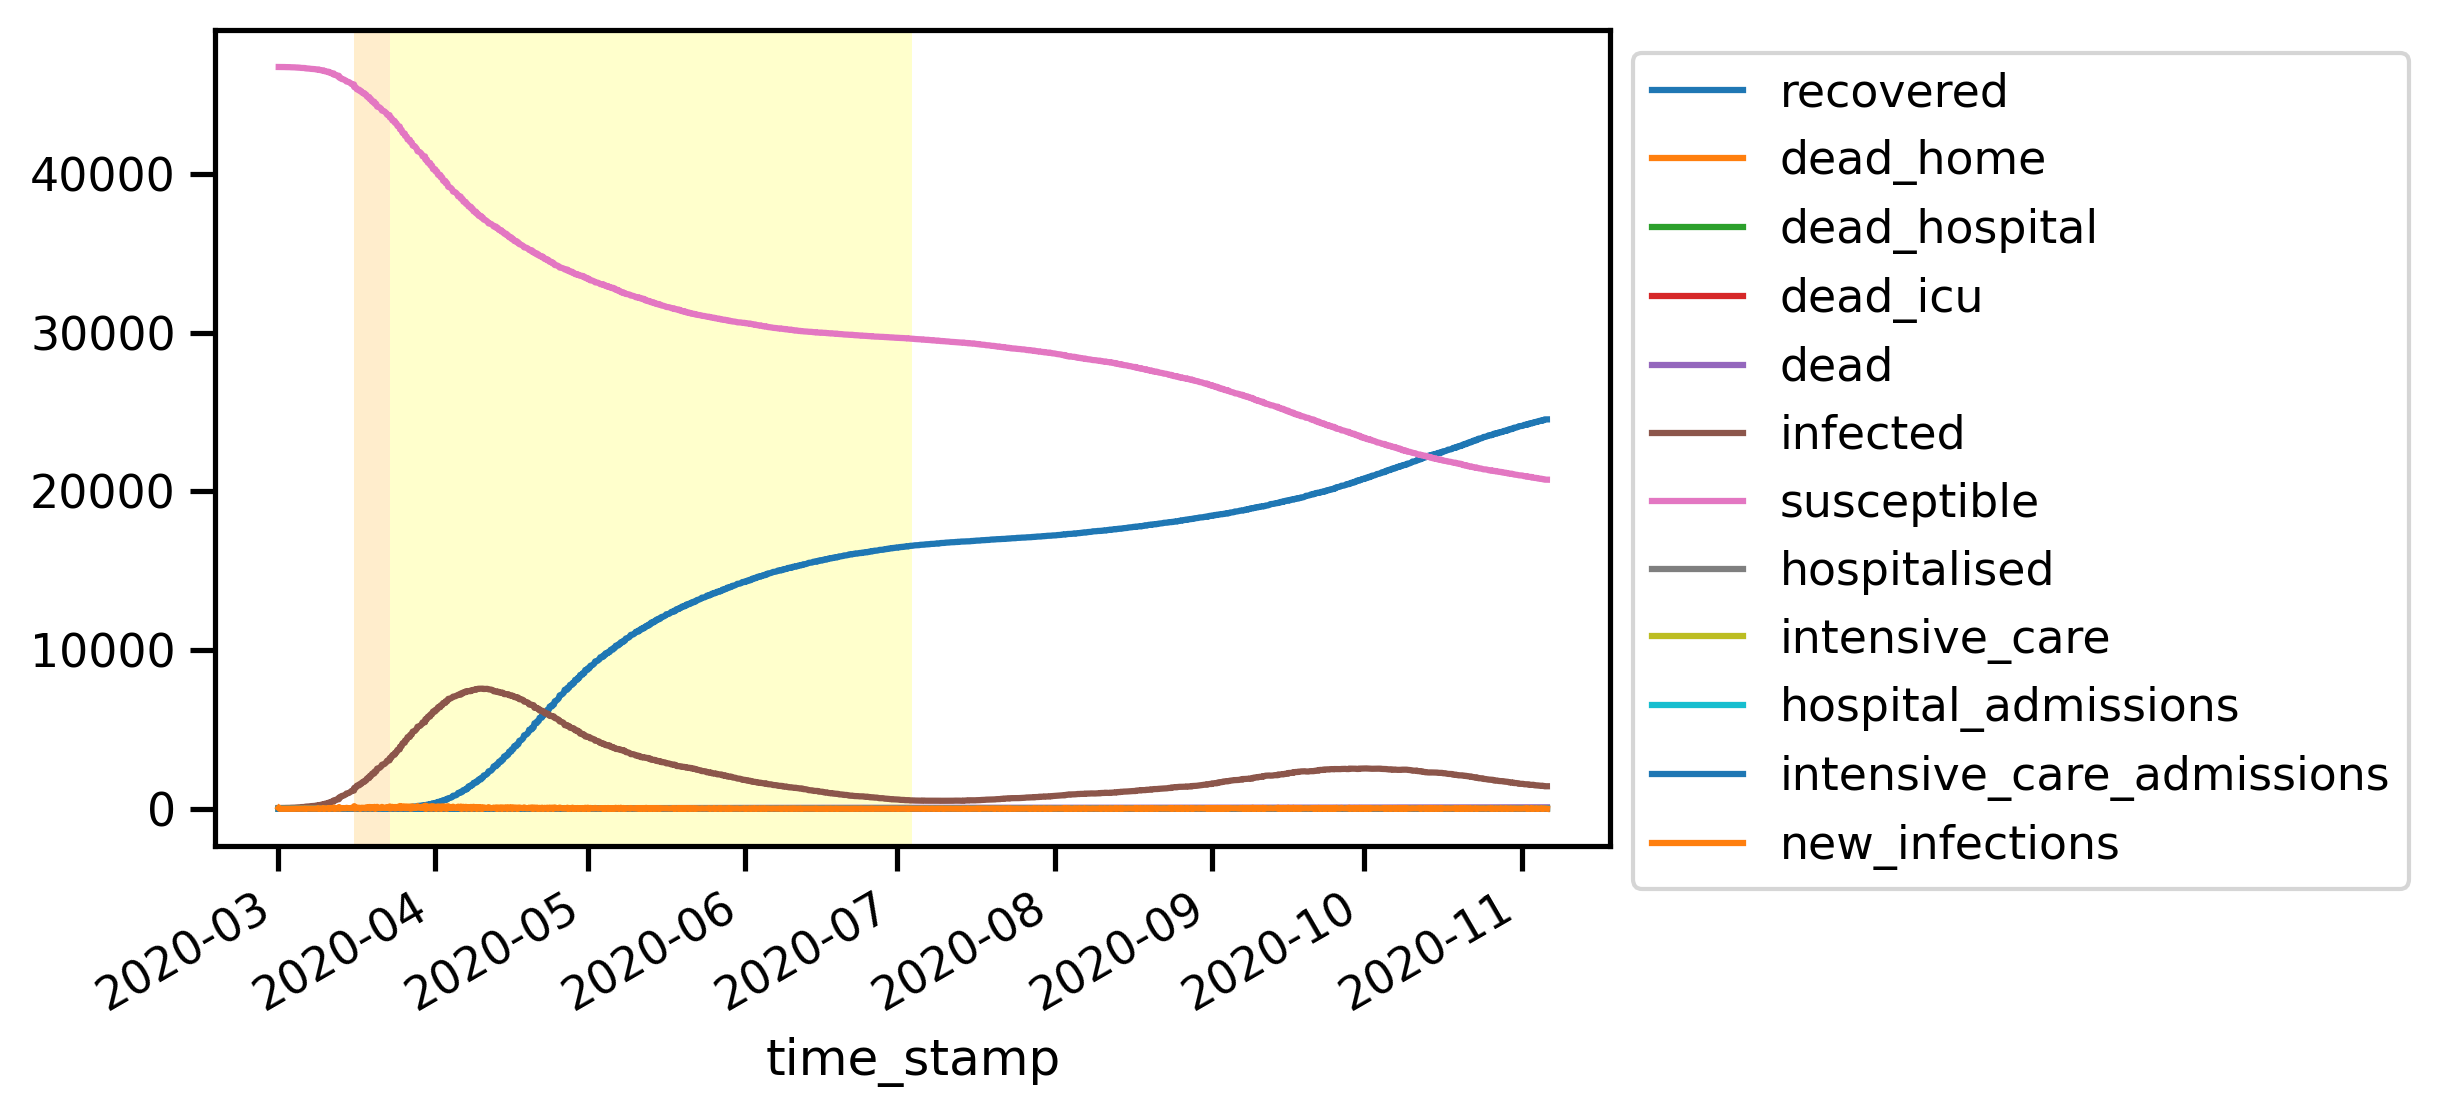

In [50]:
world_df.plot()
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


In [ ]:
area_df = read.super_area_summary()

In [ ]:
area_df[area_df.super_area == "E02003282"].plot()
plt.legend(bbox_to_anchor=(1,1))



## World infection curves per age group

In [ ]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['dead'].cumsum().plot(label=name)
plt.legend()

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['susceptible'].plot(label=name)
plt.legend()

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['hospital_admissions'].cumsum().plot(label=name)
plt.legend()

In [ ]:
for name, group in ages_df.groupby('age_range'):
    group['intensive_care_admissions'].cumsum().plot(label=name)
plt.legend()

## Draw some of the symptoms trajectories

In [ ]:
random_trajectories = read.draw_symptom_trajectories(window_length=600,
                                        n_people=10)

In [ ]:
from june.infection import SymptomTag

In [ ]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


In [ ]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

In [ ]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')